# Spectral Resolution Tests

### Using synthetic spectra, how well can we determine wavelength and plate scale for TOLIMAN?

In [2]:
import numpy as np
import matplotlib.pyplot as plt 

%matplotlib inline
import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
mpl.rcParams['font.size']=14               #10 
mpl.rcParams['savefig.dpi']= 200             #72 

import pysynphot as S

import specutils
from specutils.spectra import Spectrum1D
from astropy.io import fits as pyfits
from astropy.wcs import WCS
from astropy.io import fits
from scipy.ndimage.filters import gaussian_filter1d

In [39]:
# use Phoenix models for Teff, metallicity (dex), log g in that order 

# alpha cen A: Teff = 5790, Z = 0.20, log g = 4.30
acenA = S.Icat('phoenix',5790,0.2,4.30)

# alpha cen B: Teff = 5260, Z = 0.23, log g = 4.37
acenB = S.Icat('phoenix',5260,0.23,4.37)

In [40]:
wavels = np.linspace(3000,9000,50000)
specA = acenA.sample(wavels)
specB = acenB.sample(wavels)

## Let's plot some toy spectra

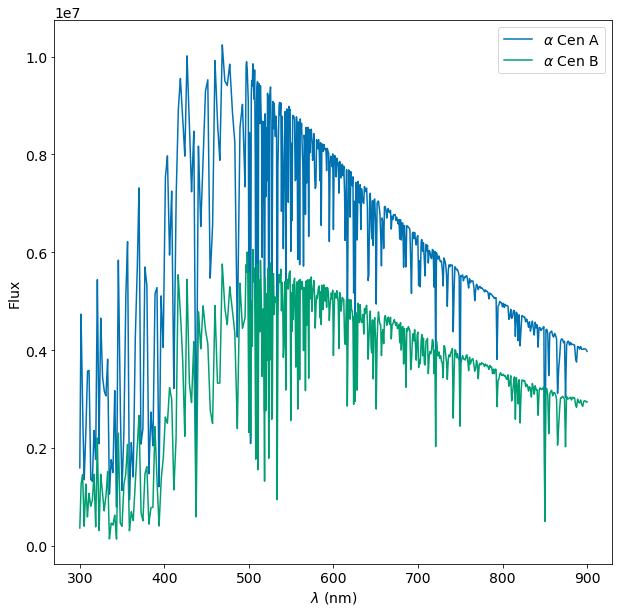

In [41]:
plt.plot(wavels/10.,specA,label=r'$\alpha$ Cen A')
plt.plot(wavels/10.,specB,label=r'$\alpha$ Cen B')
plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel('Flux')
plt.legend()

## For TOLIMAN let's assume optical properties of HST WFC3, with a 500-600 nm bandpass

In [63]:
bp = S.ObsBandpass('wfc3,uvis1,f547m')
bandpass = bp.sample(wavels)

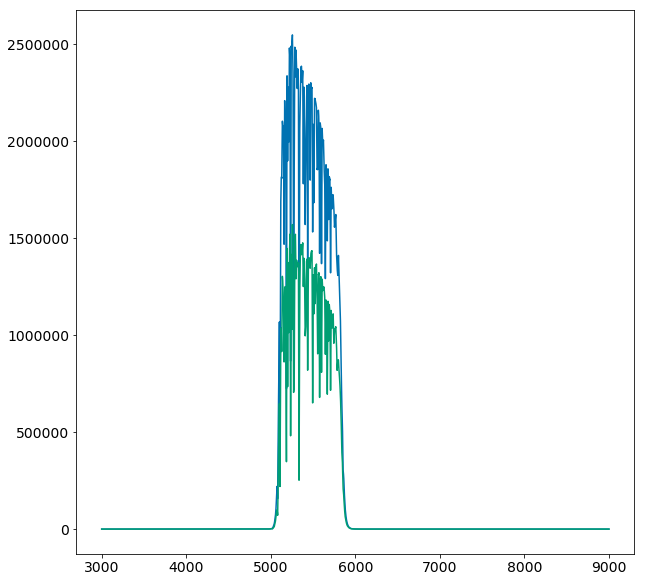

In [64]:
plt.plot(wavels,specA*bandpass)
plt.plot(wavels,specB*bandpass)

There is a UVES tutorial at http://www.astropy.org/astropy-tutorials/UVES.html

### Now what we want to do is simulate the change in centroid as you scan in temperature

In [65]:
T_surface = 5790
T_spot = 4700

fractions = np.linspace(0.01,0.15,15)
surface = S.Icat('phoenix',T_surface,0.2,4.30)
spot = S.Icat('phoenix',T_spot,0.2,4.30)

surf_spec = surface.sample(wavels)
spot_spec = spot.sample(wavels)

centres = []

for frac in fractions:
    this_spec = (1-frac)*surf_spec + (frac)*spot_spec
    this_spec *= bandpass
    
    centres.append(np.sum(wavels*this_spec)/np.sum(this_spec))
    
centres = np.array(centres)
diffs = (centres-centres[0])/centres[0]

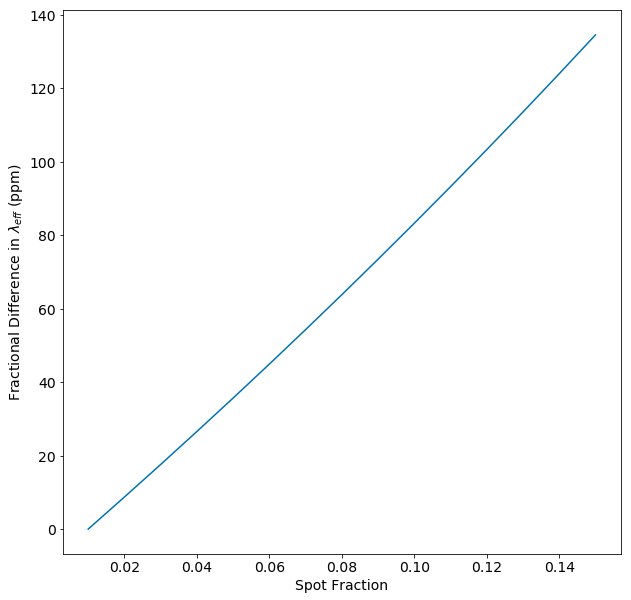

In [66]:
plt.plot(fractions,diffs*1e6)
plt.xlabel('Spot Fraction')
plt.ylabel(r'Fractional Difference in $\lambda_{eff}$ (ppm)')

### We want sub-ppm change in effective wavelength - let's try a narrower band?

In [90]:
nbp = S.ObsBandpass('wfc3,uvis1,f502n')
nbp = S.ObsBandpass('wfc3,uvis1,f631n')
nbp = S.ObsBandpass('wfc3,uvis1,f645n')

narrow = nbp.sample(wavels)

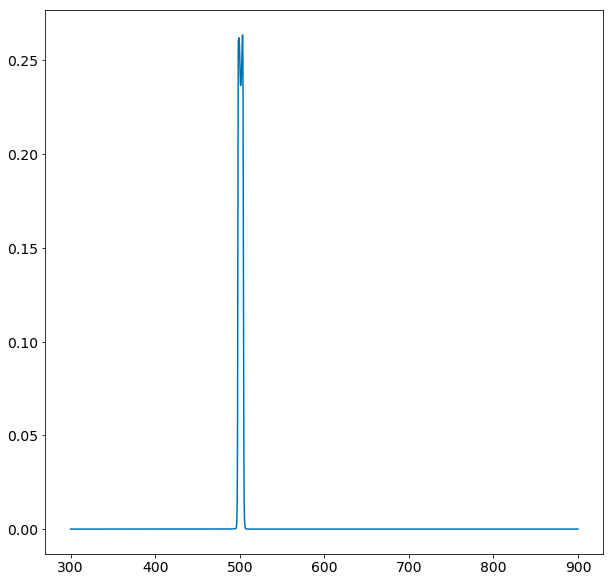

In [91]:
plt.plot(wavels/10.,narrow)
# plt.xlim(480,520)

In [92]:
T_surface = 5790
T_spot = 4700

fractions = np.linspace(0.01,0.15,15)
surface = S.Icat('phoenix',T_surface,0.2,4.30)
spot = S.Icat('phoenix',T_spot,0.2,4.30)

surf_spec = surface.sample(wavels)
spot_spec = spot.sample(wavels)

centres = []

for frac in fractions:
    this_spec = (1-frac)*surf_spec + (frac)*spot_spec
    this_spec *= narrow
    
    centres.append(np.sum(wavels*this_spec)/np.sum(this_spec))
    
centres = np.array(centres)
diffs = (centres-centres[0])/centres[0]

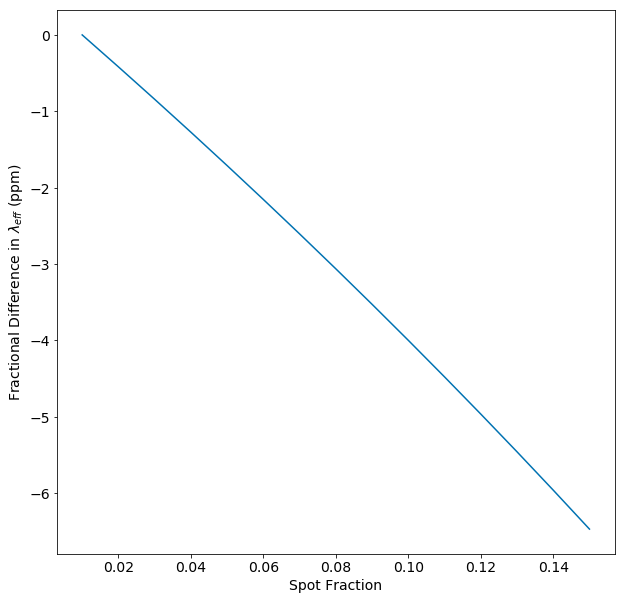

In [93]:
plt.plot(fractions,diffs*1e6)
plt.xlabel('Spot Fraction')
plt.ylabel(r'Fractional Difference in $\lambda_{eff}$ (ppm)')

### So a 100 nm bandpass gives you ~ tens of ppm change in effective wavelength, but 10 nm gives you ~ a few ppm. It is better to put this in some spectral regions than others! 

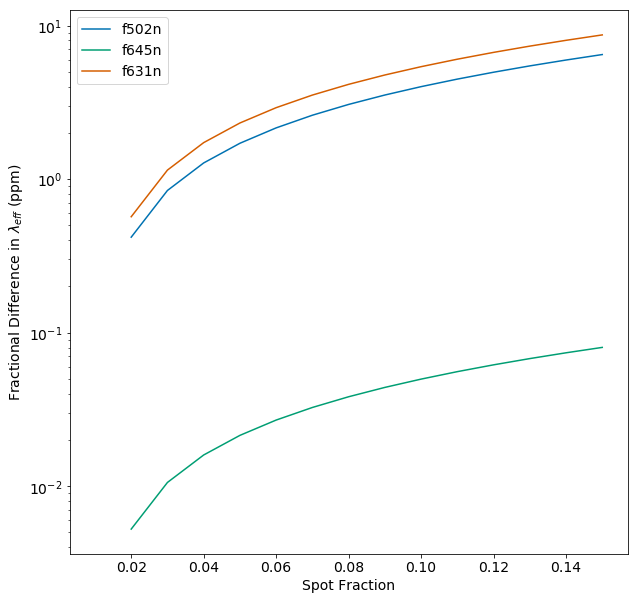

In [97]:
filters = ['f502n','f645n','f631n']

for filt in filters:
    
    nbp = S.ObsBandpass('wfc3,uvis1,%s'%filt)

    narrow = nbp.sample(wavels)
    
    centres = []

    for frac in fractions:
        this_spec = (1-frac)*surf_spec + (frac)*spot_spec
        this_spec *= narrow

        centres.append(np.sum(wavels*this_spec)/np.sum(this_spec))

    centres = np.array(centres)
    diffs = np.abs((centres-centres[0])/centres[0])
    
    plt.semilogy(fractions,diffs*1e6,label=filt)
    
    
plt.xlabel('Spot Fraction')
plt.ylabel(r'Fractional Difference in $\lambda_{eff}$ (ppm)')
plt.legend()